<a href="https://colab.research.google.com/github/IcaroTheCreator/Predicoes-de-lesoes-em-esportes/blob/main/Modelos%20-%20v2/FINAL_MLP_(500).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importando as bibliotecas necessárias para processamento de dados, plotagem gráfica e treinamento dos modelos

import numpy as np
import pandas as pd #processamento de dados, para abrir o dataset (arquivo .csv)
import itertools
import seaborn as sns
from sklearn.model_selection import train_test_split
!pip install mglearn

from google.colab import drive #para conectar o google drive ao notebook e trazer os datasets para cá
drive.mount('/content/drive') #diretório onde o drive vai ser instaurado

'''#from google.colab import files''' #função import para justamente fazer o upload dos arquivos do drive
'''uploaded = files.upload()''' #para caso de upload

# para caso de usar imagens
import PIL
from PIL import Image

# para plotagem de gráficos
import matplotlib.pyplot as plt #biblioteca mais comum para plotar as imagens
import seaborn as sns
import scipy.stats as ss

# bibliotecas e modelos para o treinamento dos modelos
from sklearn.model_selection import StratifiedKFold #função da biblioteca sklearn para dividir os sets de maneira estratificada
from sklearn.model_selection import train_test_split #função da biblioteca sklearn para dividir os sets de maneira padrão
from imblearn.over_sampling import RandomOverSampler, SMOTE #funções para over sampling (aumentar quantidade de ex da classe minoritária (lesão))
import xgboost as xgb #um dos modelos de ML
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score #funções que irão avaliar os modelos por meio de scores
from sklearn.metrics import (ConfusionMatrixDisplay, f1_score, classification_report) #mais funções para avaliação do modelo
from sklearn.tree import export_graphviz #função para imprimir a árvore de decisão
import graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 7.6 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
play_df = pd.read_csv('/content/drive/My Drive/Datasets/PlayList.csv')
#player_df = pd.read_csv('/content/drive/My Drive/Datasets/PlayerTrackData.csv')
#este último dataset foi descartado pois ele pesa 3.7 GB e estoura a memória RAM gratuita do Colab e também seus dados não afetam o treinamento de nossos modelos
injury_df = pd.read_csv('/content/drive/My Drive/Datasets/InjuryRecord.csv')

In [ ]:
# Criar um DataFrame com informações a nível de jogo.
game_df = play_df[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']].drop_duplicates().reset_index().drop(columns=['index'])

In [ ]:
def clean_weather(row):
    cloudy = ['Cloudy 50% change of rain', 'Hazy', 'Cloudy.', 'Overcast', 'Mostly Cloudy',
          'Cloudy, fog started developing in 2nd quarter', 'Partly Cloudy',
          'Mostly cloudy', 'Rain Chance 40%',' Partly cloudy', 'Party Cloudy',
          'Rain likely, temps in low 40s', 'Partly Clouidy', 'Cloudy, 50% change of rain','Mostly Coudy', '10% Chance of Rain',
          'Cloudy, chance of rain', '30% Chance of Rain', 'Cloudy, light snow accumulating 1-3"',
          'cloudy', 'Coudy', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy fog started developing in 2nd quarter', 'Cloudy light snow accumulating 1-3"',
         'Cloudywith periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy 50% change of rain', 'Cloudy and cold',
       'Cloudy and Cool', 'Partly cloudy']

    clear = ['Clear, Windy',' Clear to Cloudy', 'Clear, highs to upper 80s',
             'Clear and clear','Partly sunny',
             'Clear, Windy', 'Clear skies', 'Sunny', 'Partly Sunny', 'Mostly Sunny', 'Clear Skies',
             'Sunny Skies', 'Partly clear', 'Fair', 'Sunny, highs to upper 80s', 'Sun & clouds', 'Mostly sunny','Sunny, Windy',
             'Mostly Sunny Skies', 'Clear and Sunny', 'Clear and sunny','Clear to Partly Cloudy', 'Clear Skies',
            'Clear and cold', 'Clear and warm', 'Clear and Cool', 'Sunny and cold', 'Sunny and warm', 'Sunny and clear']

    rainy = ['Rainy', 'Scattered Showers', 'Showers', 'Cloudy Rain', 'Light Rain', 'Rain shower', 'Rain likely, temps in low 40s.', 'Cloudy, Rain']

    snow = ['Heavy lake effect snow']

    indoor = ['Controlled Climate', 'Indoors', 'N/A Indoor', 'N/A (Indoors)']

    if row.Weather in cloudy:
        return 'Cloudy'

    if row.Weather in indoor:
        return 'Indoor'

    if row.Weather in clear:
        return 'Clear'

    if row.Weather in rainy:
        return 'Rain'

    if row.Weather in snow:
        return 'Snow'

    if row.Weather in ['Cloudy.', 'Heat Index 95', 'Cold']:
        return np.nan

    return row.Weather

def clean_stadiumtype(row):
    if row.StadiumType in ['Bowl', 'Heinz Field', 'Cloudy']:
        return np.nan
    else:
        return row.StadiumType

def clean_play_df(play_df):
    play_df_cleaned = play_df.copy()

    # Realiza uma limpeza na variável 'StadiumType'
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Oudoor|Outdoors|Ourdoor|Outddors|Outdor|Outside', 'Outdoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Indoors|Indoor, Roof Closed|Indoor, Open Roof', 'Indoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Closed Dome|Domed, closed|Domed, Open|Domed, open|Dome, closed|Domed', 'Dome')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Retr. Roof-Closed|Outdoor Retr Roof-Open|Retr. Roof - Closed|Retr. Roof-Open|Retr. Roof - Open|Retr. Roof Closed', 'Retractable Roof')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace('Open', 'Outdoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned.apply(lambda row: clean_stadiumtype(row), axis=1)

    # Realiza uma limpeza na variável 'Weather'
    play_df_cleaned['Weather'] = play_df_cleaned.apply(lambda row: clean_weather(row), axis=1)

    return play_df_cleaned

In [ ]:
#Cria o dataframe de jogadas com dados já limpos
play_df_cleaned = clean_play_df(play_df)
game_df_cleaned = play_df_cleaned[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']].drop_duplicates().reset_index().drop(columns=['index'])

<ipython-input-4-e39945693612>:56: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Oudoor|Outdoors|Ourdoor|Outddors|Outdor|Outside', 'Outdoor')
<ipython-input-4-e39945693612>:57: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Indoors|Indoor, Roof Closed|Indoor, Open Roof', 'Indoor')
<ipython-input-4-e39945693612>:58: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Closed Dome|Domed, closed|Domed, Open|Domed, open|Dome, closed|Domed', 'Dome')
<ipython-input-4-e39945693612>:59: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cle

In [ ]:
# Começa as modificações no dataframe
play_injury_df = injury_df.dropna(subset=['PlayKey']).set_index('PlayKey').join(play_df_cleaned.set_index('PlayKey'), how = 'outer', lsuffix='_left', rsuffix='_right')

# Preenche as colunas vazias com zeros
play_injury_df['DM_M1'] = play_injury_df['DM_M1'].fillna(0).astype(int)
play_injury_df['DM_M7'] = play_injury_df['DM_M7'].fillna(0).astype(int)
play_injury_df['DM_M28'] = play_injury_df['DM_M28'].fillna(0).astype(int)
play_injury_df['DM_M42'] = play_injury_df['DM_M42'].fillna(0).astype(int)

# Coloca um sinal de lesão nas colunas que ocorrem as lesões
play_injury_df.DM_M1 = play_injury_df.DM_M1 - play_injury_df.DM_M7
play_injury_df.DM_M7 = play_injury_df.DM_M7 - play_injury_df.DM_M28
play_injury_df.DM_M28 = play_injury_df.DM_M28 - play_injury_df.DM_M42

play_injury_df['Injury'] = play_injury_df['DM_M1'] + play_injury_df['DM_M7'] + play_injury_df['DM_M28']+ play_injury_df['DM_M42']

# Dispensa as colunas duplicadas da variável 'Surface'
play_injury_df = play_injury_df.drop(columns=['Surface'])

# Cria variáveis dummy
play_injury_df_dummies = pd.get_dummies(play_injury_df, columns = ['PlayType', 'PositionGroup'], dummy_na = True, drop_first = True)

In [ ]:
def visualize_play(play_df_cleaned):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(1,1,figsize=(15,5))

    plt.bar(play_df_cleaned.PlayType.value_counts().keys().values, play_df_cleaned.PlayType.value_counts().values)
    plt.xticks(range(len(play_df_cleaned.PlayType.value_counts().keys().values)), play_df_cleaned.PlayType.value_counts().keys().values, rotation=20)
    add_value_labels(ax, spacing=5)
    plt.title('Play-Level Exploration: PlayType', fontsize=16)

    plt.show()

#plotando as situações de cada jogada

In [ ]:
#Criando o dataframe com os dados das jogadas já limpos
play_df_cleaned = clean_play_df(play_df)
game_df_cleaned = play_df_cleaned[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']].drop_duplicates().reset_index().drop(columns=['index'])

<ipython-input-4-e39945693612>:56: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Oudoor|Outdoors|Ourdoor|Outddors|Outdor|Outside', 'Outdoor')
<ipython-input-4-e39945693612>:57: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Indoors|Indoor, Roof Closed|Indoor, Open Roof', 'Indoor')
<ipython-input-4-e39945693612>:58: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Closed Dome|Domed, closed|Domed, Open|Domed, open|Dome, closed|Domed', 'Dome')
<ipython-input-4-e39945693612>:59: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cle

In [ ]:
# Juntou o conjunto de dados de jogos limpo com o conjunto de dados de lesões.
game_injury_df = injury_df.set_index('GameID').join(game_df_cleaned.set_index('GameID'), how = 'outer')

# Preenche os valores nulos nas colunas de lesões com zeros.
game_injury_df['DM_M1'] = game_injury_df['DM_M1'].fillna(0).astype(int)
game_injury_df['DM_M7'] = game_injury_df['DM_M7'].fillna(0).astype(int)
game_injury_df['DM_M28'] = game_injury_df['DM_M28'].fillna(0).astype(int)
game_injury_df['DM_M42'] = game_injury_df['DM_M42'].fillna(0).astype(int)

game_injury_df.DM_M1 = game_injury_df.DM_M1 - game_injury_df.DM_M7
game_injury_df.DM_M7 = game_injury_df.DM_M7 - game_injury_df.DM_M28
game_injury_df.DM_M28 = game_injury_df.DM_M28 - game_injury_df.DM_M42

# Introduz uma coluna com uma flag indicando uma lesão.
game_injury_df['Injury'] = game_injury_df['DM_M1'] + game_injury_df['DM_M7'] + game_injury_df['DM_M28'] + game_injury_df['DM_M42']

# Remove a coluna de superfície duplicada.
game_injury_df = game_injury_df.drop(columns=['Surface'])

# Remove as características do nível de jogada por enquanto.
game_injury_df = game_injury_df.drop(columns=['PlayerKey', 'PlayKey'])

# Cria variáveis dummy
game_injury_df_dummies = pd.get_dummies(game_injury_df, dummy_na = True, drop_first = True).drop(columns=['FieldType_nan'])

In [ ]:
# reinicia o índice
features_df = play_injury_df.copy().reset_index()
# descarta as colunas irrelevantes
features_df = features_df.drop(columns=['PlayerKey_left','GameID_left','BodyPart', 'PlayKey', 'PlayerKey_right', 'GameID_right', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42', 'RosterPosition'])
# as transforma em váriáveis dummy
features_df = pd.get_dummies(features_df, dummy_na = False, drop_first = True)

In [ ]:
#aqui que muda, haverá um segundo descarte de features, com base na filtragem de feature_importance menor que 0.01
features_df = features_df.drop(columns=['PositionGroup_LB'])
#features_df = features_df.drop(columns=['RosterPosition_Linebacker'])
features_df = features_df.drop(columns=['PositionGroup_Missing Data'])
features_df = features_df.drop(columns=['PositionGroup_QB'])
features_df = features_df.drop(columns=['Position_WR'])
features_df = features_df.drop(columns=['Position_RB'])
features_df = features_df.drop(columns=['Position_TE'])
features_df = features_df.drop(columns=['PositionGroup_RB'])
features_df = features_df.drop(columns=['PositionGroup_SPEC'])
features_df = features_df.drop(columns=['PositionGroup_TE'])
features_df = features_df.drop(columns=['Position_S'])
features_df = features_df.drop(columns=['Position_ILB'])
features_df = features_df.drop(columns=['Position_QB'])
features_df = features_df.drop(columns=['Position_P'])
features_df = features_df.drop(columns=['Position_NT'])
features_df = features_df.drop(columns=['Position_Missing Data'])
features_df = features_df.drop(columns=['Position_LB'])
features_df = features_df.drop(columns=['Position_K'])
features_df = features_df.drop(columns=['Position_HB'])
#features_df = features_df.drop(columns=['RosterPosition_Kicker'])
features_df = features_df.drop(columns=['Position_DE'])
features_df = features_df.drop(columns=['Position_DB'])
features_df = features_df.drop(columns=['PlayType_Punt Not Returned'])
features_df = features_df.drop(columns=['PlayType_Kickoff Returned'])
features_df = features_df.drop(columns=['Weather_Snow'])
features_df = features_df.drop(columns=['PositionGroup_WR'])
features_df = features_df.drop(columns=['Position_FS'])


In [ ]:
#separando o features_df em 2 datasets, um com injury igual a 0 e o outro com injury igual a 1_
features_df0 = features_df[features_df['Injury'] < 1]
features_df1 = features_df[features_df['Injury'] >= 1]


In [ ]:
#agora, dividindo o features_df0 em 2 partes, um com 323 amostras para treino e outro com 266706 amostras para testes
features_df0_treino = features_df0.iloc[:423, :]
features_df0_teste = features_df0.iloc[423:, :]
print("Shape of new dataframes - {} , {}".format(features_df0_treino.shape, features_df0_teste.shape))

Shape of new dataframes - (423, 29) , (266506, 29)


In [ ]:
#juntando o dataset de injury = 1 com as 223 amostras de treino
frames = [features_df1, features_df0_treino]
new_treino_df = pd.concat(frames)
new_treino_df.reset_index(inplace=True)
new_treino_df = new_treino_df.drop(columns=['index'])

In [ ]:
#juntando o dataset de injury = 1 com as 266706 amostras de teste
frames2 = [features_df1, features_df0_teste]
new_teste_df = pd.concat(frames2)
new_teste_df.reset_index(inplace=True)
new_teste_df = new_teste_df.drop(columns=['index'])

In [ ]:
#separa em features e targets (treino)
y = new_treino_df['Injury']
X = new_treino_df.drop(columns=['Injury'])

In [ ]:
#separa em features e targets (teste)
y_2 = new_teste_df['Injury']
X_2 = new_teste_df.drop(columns=['Injury'])

In [ ]:
skf = StratifiedKFold(n_splits=2)
#usa separação estratificada para treinar o conjunto de treino para distribuir igualmente os rótulos em todas as classes
for train_index, train_index in skf.split(X, y):
    X_train = X.values[train_index, :]
    y_train = y[train_index]

In [ ]:
X_train.shape

(250, 28)

In [ ]:
skf = StratifiedKFold(n_splits=2)
#usa separação estratificada para dividir os conjuntos de testes para distribuir igualmente os rótulos em todas as classes
for test_index, test_index in skf.split(X_2, y_2):
    X_teste = X_2.values[test_index, :]
    y_teste = y_2[test_index]

In [ ]:
'''res = RandomOverSampler(random_state=0)
X_resampled, y_resampled = res.fit_resample(X_train, y_train)
X_teste, y_teste = res.fit_resample(X_test, y_test)'''
#com um número ínfimo de lesões, é preciso rearranjar o dataset para a predição não resultar sempre em não lesão

'res = RandomOverSampler(random_state=0)\nX_resampled, y_resampled = res.fit_resample(X_train, y_train)\nX_teste, y_teste = res.fit_resample(X_test, y_test)'

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver = 'lbfgs', max_iter = 100000, random_state=42).fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_teste, y_teste)))

Accuracy on training set: 1.000
Accuracy on test set: 0.138


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


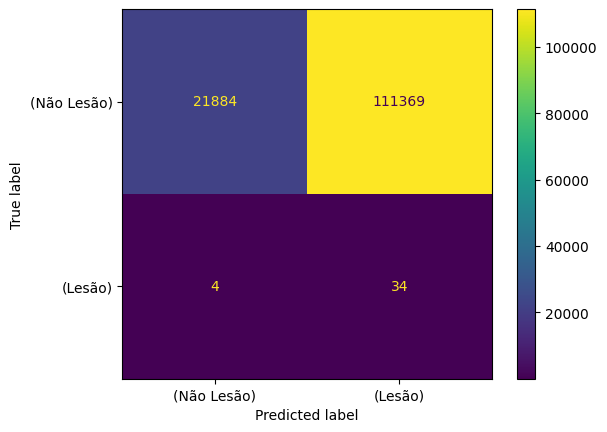

In [ ]:
model = MLPClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_teste)


labels = ["(Não Lesão)", "(Lesão)"]
cm = confusion_matrix(y_teste, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

In [ ]:
'''import mglearn


mglearn.plots.plot_2d_separator(mlp, X_resampled, fill=True, alpha=.3)
mglearn.discrete_scatter(X_resampled[:, 0], X_2[:, 1], y_2)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")'''

'import mglearn\n\n\nmglearn.plots.plot_2d_separator(mlp, X_resampled, fill=True, alpha=.3)\nmglearn.discrete_scatter(X_resampled[:, 0], X_2[:, 1], y_2)\nplt.xlabel("Feature 0")\nplt.ylabel("Feature 1")'